## Распознавание рукописного ввода на примере базы MNIST

In [219]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Загружаем исходные данные

In [220]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [221]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [222]:
train = train.to_numpy()

In [223]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
train_label

array([1, 0, 1, ..., 7, 6, 9])

In [224]:
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))

In [225]:
train_img.shape

(42000, 28, 28)

### Визуализируем исходные данные

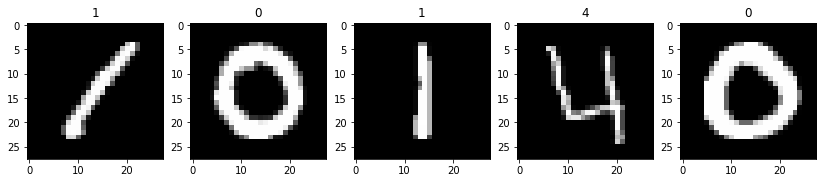

In [226]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Получение признаков для классификации с понижением размерности

### 1.  Гистограммы градиентов (HOG)

In [332]:
from skimage.feature import hog

list_hog = []

for feature in train_img:
    
    fd = hog(feature.reshape((28,28)), orientations=8, pixels_per_cell=(14,14), cells_per_block=(1,1), block_norm= 'L2')
    list_hog.append(fd)
    
hog_features = np.array(list_hog, 'float64')

In [333]:
hog_features

array([[0.48223409, 0.8760424 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.66910118, 0.34847036, 0.56167257, ..., 0.        , 0.04906438,
        0.13110362],
       [0.89965592, 0.19665501, 0.09951763, ..., 0.        , 0.        ,
        0.01599602],
       ...,
       [0.23462175, 0.04995738, 0.52143565, ..., 0.        , 0.        ,
        0.        ],
       [0.29604274, 0.90233478, 0.31314042, ..., 0.04657658, 0.09997244,
        0.07748885],
       [0.05215682, 0.48451538, 0.87136868, ..., 0.        , 0.08300736,
        0.25050571]])

Масштабируем каждый объект по его максимальному абсолютному значению (стандартизируем данные)

In [324]:
from sklearn import preprocessing

preProcess = preprocessing.MaxAbsScaler().fit(hog_features)
hog_features_transformed = preProcess.transform(hog_features)

hog_features_transformed

array([[0.48223409, 0.8760424 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.66910118, 0.34847036, 0.56167257, ..., 0.        , 0.0498361 ,
        0.13779958],
       [0.89965592, 0.19665501, 0.09951763, ..., 0.        , 0.        ,
        0.01681299],
       ...,
       [0.23462175, 0.04995738, 0.52143565, ..., 0.        , 0.        ,
        0.        ],
       [0.29604274, 0.90233478, 0.31314042, ..., 0.04997516, 0.10154488,
        0.0814465 ],
       [0.05215682, 0.48451538, 0.87136868, ..., 0.        , 0.08431297,
        0.26329999]])

In [325]:
X_train, X_test, y_train, y_test = train_test_split(hog_features_transformed, train_label, random_state = 0)

In [326]:
from sklearn import svm

clf = svm.SVC()
clf.fit(X_train, y_train)

SVC()

In [327]:
from sklearn import metrics

y_pred = clf.predict(X_test)

print("Accuracy: "+ str(metrics.accuracy_score(y_test, y_pred)))

Accuracy: 0.9396190476190476


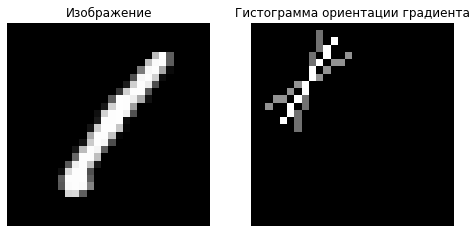

In [405]:
from skimage.exposure import rescale_intensity


_, hog_image = hog(train_img[0], orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(train_img[0], cmap=plt.cm.gray)
ax1.set_title('Изображение')

hog_image_rescaled = rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Гистограмма ориентации градиента')
plt.show()

### 2. PCA - метод главных компанент

In [187]:
# выбираем картинки случайным образом (10к)
choices = np.random.choice(train_img.shape[0], 10000)
#буду преобразовывать картинки в вектора (train_img - матрица)
y = train_label[choices]
X = train_img[choices].reshape(-1, 28 * 28).astype(np.float32)#-1 - размер датасета (10000)

In [188]:
X.shape #28*28=784

(10000, 784)

In [189]:
X_mean = X.mean(axis=0)
# центрируем данные (вычитаем среднее)
X = X - X_mean

In [190]:
# матрица ковариации признаков
cov = np.dot(X.T, X) / X.shape[0]

In [191]:
#Функция linalg.svd() выполняет сингулярное (SVD) разложение. 
U, S, _ = np.linalg.svd(cov)
# U - сингулярные вектора матрицы ковариации
# S - сингулярные значения

In [192]:
#сингулярные значения хранятся в убывающем порядке
S[:10]

array([332167.8  , 243560.8  , 218534.42 , 184427.56 , 163598.45 ,
       146058.69 , 112687.055,  97823.43 ,  93993.3  ,  82960.62 ],
      dtype=float32)

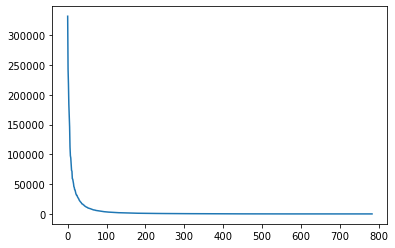

In [193]:
#нарисуем их
plt.plot(range(len(S)), S)

Text(0.5, 0, 'Полная сумма сингулярнных значений')

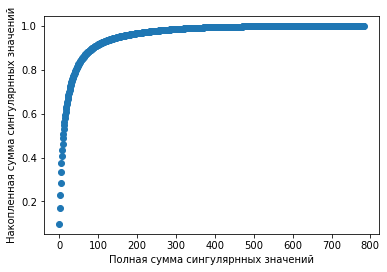

In [194]:
# накопленная сумма сингулярнных значений (np.cumsum - накопленная сумма)
S_cumsum = np.cumsum(S) / np.sum(S)
fig, ax = plt.subplots()
plt.plot(S_cumsum, 'o')
ax.set_ylabel('Накопленная сумма сингулярнных значений')
ax.set_xlabel('Полная сумма сингулярнных значений')

In [195]:
#задаем порог для накопленной суммы
S_thr = 0.8

# определяем необходимое число компонент для заданного порога
n_comp = np.argmax(np.where(S_cumsum > S_thr, 1, 0))

print('Число компонент=%d, Накопленная сумма от=%.3f' % (n_comp, S_cumsum[n_comp]))

Число компонент=42, Накопленная сумма от=0.801


In [196]:
# получаем сжатое представление объектов
X_train_pca = np.dot(X, U[:, :n_comp])

In [197]:
X_train_pca.shape

(10000, 42)

**Визуализация сингулярных векторов**

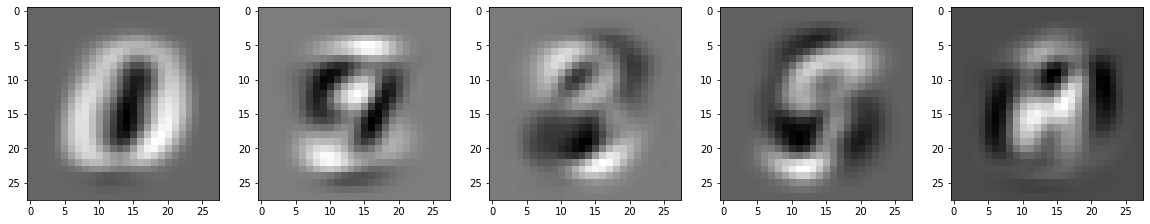

In [231]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(U.T[:5, :], 1):
    subplot = fig.add_subplot(1, 5, i)
    plt.imshow(img.reshape((28,28)), cmap='gray');

In [200]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train_pca, y, test_size=0.30, random_state=4)

**Востанавливаем изображение после понижения размерности**

In [215]:
Xrot_restored = np.dot(X_train_pca, U[:,:n_comp].T)

In [216]:
Xrot_restored.shape

(10000, 784)

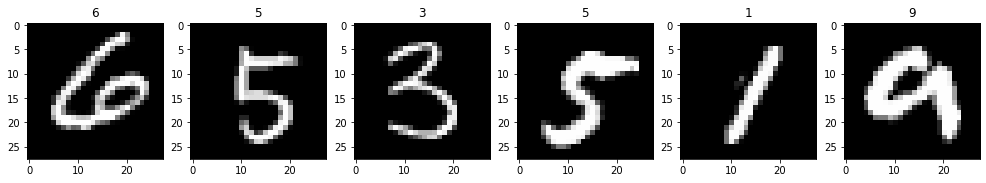

In [217]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(X[0:6], 1):
    subplot = fig.add_subplot(1, 7, i)
    img_ = img + X_mean
    plt.title('%s' % y[i-1])
    plt.imshow(img_.reshape((28,28)), cmap='gray');

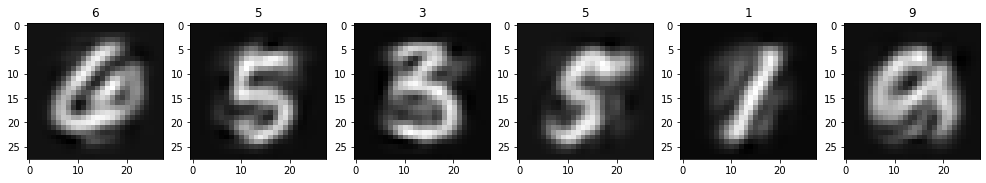

In [218]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(Xrot_restored[0:6], 1):
    subplot = fig.add_subplot(1, 7, i)
    img_ = img + X_mean
    plt.title('%s' % y[i-1])
    plt.imshow(img_.reshape((28,28)) + X_mean.reshape((28,28)), cmap='gray');

## Классификатор

In [162]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [204]:
param_grid = { "n_neighbors" : range(1,20) }

knn = KNeighborsClassifier()
gs = GridSearchCV(estimator=knn, param_grid=param_grid, scoring='accuracy', cv=2, n_jobs=-1, verbose=1)
gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

Fitting 2 folds for each of 19 candidates, totalling 38 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


0.9395714285714285
{'n_neighbors': 1}


[Parallel(n_jobs=-1)]: Done  38 out of  38 | elapsed:    8.7s finished


In [206]:
knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

In [207]:
knn.score(X_test, y_test)

0.9543333333333334

In [208]:
metrics.accuracy_score(y_test, y_pred)

0.9543333333333334

Качество сжатия приемлемо для классификатора